## Project Intro

In this project, we will be using traffic collision data provided by the California Highway Patrol to predict whether a collision will result in a fatality or not.

This dataset contains every instance of a traffic collision in the state of California from 2001 to 2020.

For the purposes of this analysis, we will only be analysing traffic collisions that happened in the year 2020. 

A RandomForest classifier will be used to predict whether a traffic collision resulted in a fatality or not.

Since we are dealing with real life data, where a signficant imbalance exists between nonfatal and fatal accidents (99.4 / 0.6), our main metric of evaluation will be recall (or sensitivity).

Recall tells us the fraction of correctly identified positive predictions from all positive cases. In this case, a positive case is a fatal traffic accident, and therefore False Negatives are more costly than False Positives (a fatal crash predicted nonfatal vs a nonfatal crash being predicted fatal).

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
import seaborn as sns
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

This project utilized SQL to import two datasets from Kaggle and merge them using matching values based on "case_id".

In [4]:
con = sqlite3.connect("/Users/jazzopardi/Downloads/switrs.sqlite 2")

In [5]:
 query = """
 SELECT *
 FROM collisions c 
 INNER JOIN parties p ON c.case_id = p.case_id
 WHERE date(collision_date) BETWEEN date('2020-01-01') and date('2020-12-31')

 """


In [6]:
df_one = pd.read_sql_query(query, con)

In [7]:
df = pd.read_csv('proj.csv', dtype={'caltrans_county': str, 'route_suffix': str, 'postmile_prefix': str, 'location_type': str,
                                   'ramp_intersection': str, 'side_of_highway': str, 'pcf_violation_code': str, 'primary_ramp': str,
                                   'secondary_ramp':str, 'oaf_violation_code': str})

In [8]:
pd.set_option('display.max_columns', 110)
pd.set_option('display.max_rows', 110)

# EDA

The first step for any data science project is to conduct Exploratory Data Analysis. Here, we'll explore and clean our data so that it is ready for a machine learning model. This involves removing any NA values, feature selection/engineering, discretizing, coverting data types etc. 

In [9]:
df.isna().sum().sort_values(ascending = False)

oaf_violation_code                 712535
route_suffix                       712534
pcf_violation_code                 712465
primary_ramp                       711884
hazardous_materials                711855
school_bus_related                 710231
postmile_prefix                    708366
road_condition_2                   707449
secondary_ramp                     707405
ramp_intersection                  700285
weather_2                          699524
oaf_violation_suffix               698307
other_associate_factor_2           697066
chp_vehicle_type_towed             691308
side_of_highway                    690810
caltrans_district                  690791
location_type                      690791
postmile                           690791
state_route                        690791
caltrans_county                    690791
oaf_violation_category             662453
oaf_violation_section              661200
city_division_lapd                 660090
alcohol_involved                  

A decision was made to remove any variables that have over 30% "missingness".

In [10]:
# dropping columns with > 30% missing values - dimension reduction

perc = 30.0

min_count = int(((100-perc)/100)* df.shape[0] + 1)

mod_df = df.dropna(axis = 1, thresh = min_count)

Next, we drop any rows that have NAs values. We are left with a dataset with no missing values.

In [11]:
mod_df = mod_df.dropna(axis = 0)

In [12]:
mod_df.shape

(286101, 78)

In [64]:
mod_df

,population,county_location,distance,direction,intersection,weather_1,state_highway_indicator,party_count,primary_collision_factor,pcf_violation_category,pcf_violation,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,statewide_vehicle_type_at_fault,collision_time,party_number,party_type,party_sex,party_age,party_sobriety,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,cellphone_in_use,cellphone_use_type,other_associate_factor_1,movement_preceding_collision,vehicle_year,statewide_vehicle_type,party_race,year,month,day,collision_severity
3,100000 to 250000,ventura,100.0,east,0.0,clear,0.0,3,vehicle code violation,dui,23152.0,not hit and run,rear end,parked motor vehicle,no pedestrian involved,wet,normal,dark with street lights,functioning,0,0,0,0,0,1,passenger car,22:36:00,1,driver,male,27,"had been drinking, under influence",west,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,violation,proceeding straight,1989,passenger car,hispanic,2020,10,05,0
6,>250000,los angeles,33.0,east,0.0,clear,0.0,2,vehicle code violation,speeding,22350.0,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,dark with street lights,functioning,0,0,0,0,1,1,truck or truck tractor,21:25:00,1,driver,male,61,had not been drinking,west,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,none apparent,passing other vehicle,2006,truck or truck tractor,black,2020,08,06,0
7,>250000,los angeles,33.0,east,0.0,clear,0.0,2,vehicle code violation,speeding,22350.0,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,dark with street lights,functioning,0,0,0,0,1,1,truck or truck tractor,21:25:00,2,driver,male,33,had not been drinking,west,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,none apparent,proceeding straight,2013,passenger car,hispanic,2020,08,06,0
8,100000 to 250000,ventura,8.0,north,0.0,clear,0.0,2,vehicle code violation,improper turning,22107.0,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0,0,0,0,0,1,other bus,15:11:00,1,driver,male,41,had not been drinking,south,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,none apparent,making left turn,2006,other bus,hispanic,2020,10,05,0
9,100000 to 250000,ventura,8.0,north,0.0,clear,0.0,2,vehicle code violation,improper turning,22107.0,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0,0,0,0,0,1,other bus,15:11:00,2,driver,female,33,had not been drinking,north,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,none apparent,stopped,2020,passenger car,asian,2020,10,05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712522,25000 to 50000,santa clara,33.0,east,0.0,clear,0.0,2,vehicle code violation,speeding,22350.0,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,daylight,functioning,0,0,0,0,0,1,passenger car,13:20:00,1,driver,male,71,had not been drinking,west,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,none apparent,proceeding straight,2008,passenger car,white,2020,07,27,0
712523,25000 to 50000,santa clara,33.0,east,0.0,clear,0.0,2,vehicle code violation,speeding,22350.0,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,daylight,functioning,0,0,0,0,0,1,passenger car,13:20:00,2,driver,female,51,had not been drinking,west,air bag not deployed,lap/shoulder harness used,0,cellphone not in use,none apparent,slowing/stopping,2018,passenger car,other,2020,07,27,0
712533,100000 to 250000,orange,44.0,east,0.0,clear,0.0,2,vehicle code violation,d

In [13]:
mod_df.isna().any()

Unnamed: 0                         False
case_id                            False
jurisdiction                       False
officer_id                         False
chp_shift                          False
population                         False
county_city_location               False
county_location                    False
special_condition                  False
beat_type                          False
chp_beat_type                      False
chp_beat_class                     False
beat_number                        False
primary_road                       False
secondary_road                     False
distance                           False
direction                          False
intersection                       False
weather_1                          False
state_highway_indicator            False
tow_away                           False
collision_severity                 False
killed_victims                     False
injured_victims                    False
party_count     

This dataset contains 712538 rows and 78 columns. 

There are many ways to conduct feature selection. This project will explore several. 

First, we will begin by removing any columns that aren't factors of a car crash, such as "case_id" and "officer_id".

We will also remove any columns that have a high correlation with the dependent variable, which in this case is fatalities. That includes "pedestrian_killed_count", "injured_victims" etc. 

Doing so ensures that we're not adding noise to our dataset.

We will also remove columns that show signs of multicollinearity - this is again to avoid adding noise and unnecessary columns that don't have any predictive value for our model.  

An examples...

In [14]:
len(mod_df['secondary_road'].unique())

48081

There are 86246 unique values for "secondary_road". This is an instance of high cardinality. Given that this is a categorical variabel, it wil need to be encoded so that it can be readable for our model. However, encoding, such as one-hot encoding, will only result in (86248 - 1) additional columns. While other encoding methods can be used, such as target encoding used in this project, a decision was made to drop such columns instead.

In [15]:
# using domain knowledge to remove columns - these columns are the result of data input post-crash 

mod_df.drop(['case_id','Unnamed: 0','party_number_injured', 'party_number_killed',
            'financial_responsibility','case_id.1', 'id', 'process_date','severe_injury_count', 'other_visible_injury_count',
            'complaint_of_pain_injury_count', 'pedestrian_killed_count','pedestrian_injured_count','bicyclist_killed_count',
            'bicyclist_injured_count', 'motorcyclist_killed_count', 'motorcyclist_injured_count', 'injured_victims', 'killed_victims', 
            'tow_away','beat_number', 'chp_beat_class', 'chp_beat_type','beat_type', 'special_condition','chp_shift',
            'officer_id', 'chp_vehicle_type_at_fault', 'county_city_location', 'jurisdiction',
             'chp_vehicle_type_towing', 'primary_road', 'secondary_road'], axis = 1, inplace = True)


In [16]:
log_df = mod_df # storing a copy of the dataframe for when we conduct feature selection using Logistic Regression  

Let's take a closer look at the data. Using .dtypes.value_counts() we can see the majority of our variables (29) are categorical. This will inform how conduct further preprocessing for our machine learning model.

In [17]:
mod_df.dtypes.value_counts()

object     29
int64       9
float64     7
dtype: int64

In [19]:
mod_df = mod_df.drop(mod_df[mod_df['pcf_violation_category'] == 'unknown'].index)
mod_df = mod_df.drop(mod_df[mod_df['party_safety_equipment_2'] == 'unkown'].index)

In [20]:
mod_df[["year", "month", "day"]] = mod_df["collision_date"].str.split("-", expand = True)
mod_df = mod_df.drop(['collision_date'], axis = 1)

In [21]:
mod_df['population'].unique()
mod_df = mod_df.drop(mod_df[mod_df['population'] == 'unincorporated'].index)

In [22]:
mod_df['vehicle_year'] = mod_df['vehicle_year'].astype(int)
mod_df['party_age'] = mod_df['party_age'].astype(int)
mod_df['cellphone_in_use'] = mod_df['cellphone_in_use'].astype(int)

To help understand the data better, we can visualize the distribution of some variables, inlcuding party_age.

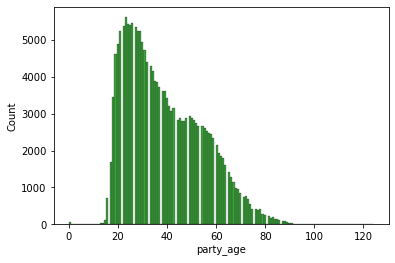

In [23]:
sns.histplot(mod_df['party_age'], color = 'g')

plt.show()

Visualizations can also help us detect outliers, such as the case with vehicle_year below.

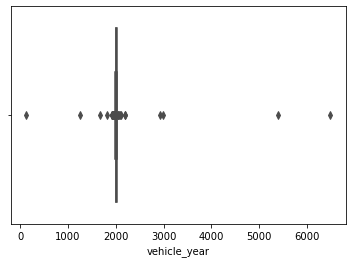

In [24]:
sns.boxplot(mod_df['vehicle_year'], color = 'r')

plt.show()

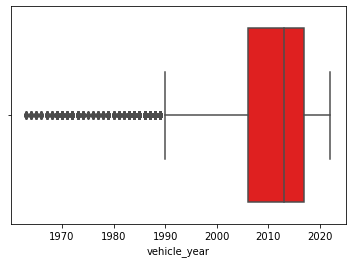

In [25]:
# removing outliers 

mod_df = mod_df[(np.abs(stats.zscore(mod_df['vehicle_year'])) < 3)]

mod_df = mod_df[mod_df['vehicle_year'] < 2030 ]

sns.boxplot(mod_df['vehicle_year'], color = 'r')

plt.show()

To organize our data better, we move the dependent variable to become the last column.

In [26]:
#move dependent variable to the end 

col_at_end = ['collision_severity']

mod_df = mod_df[[c for c in mod_df if c not in col_at_end] 
        + [c for c in col_at_end if c in mod_df]]

In [27]:
mod_df['collision_severity'] = [ 1 if x == 'fatal' else 0 for x in mod_df['collision_severity']]

mod_df['collision_severity'].unique()

array([0, 1])

## Feature Selection

We can continue with feature selection by building a heat map to visualize which variables share a strong correlation with one another. Those that do aren't beneficial to our analysis, so we'll simply remove one of the two.

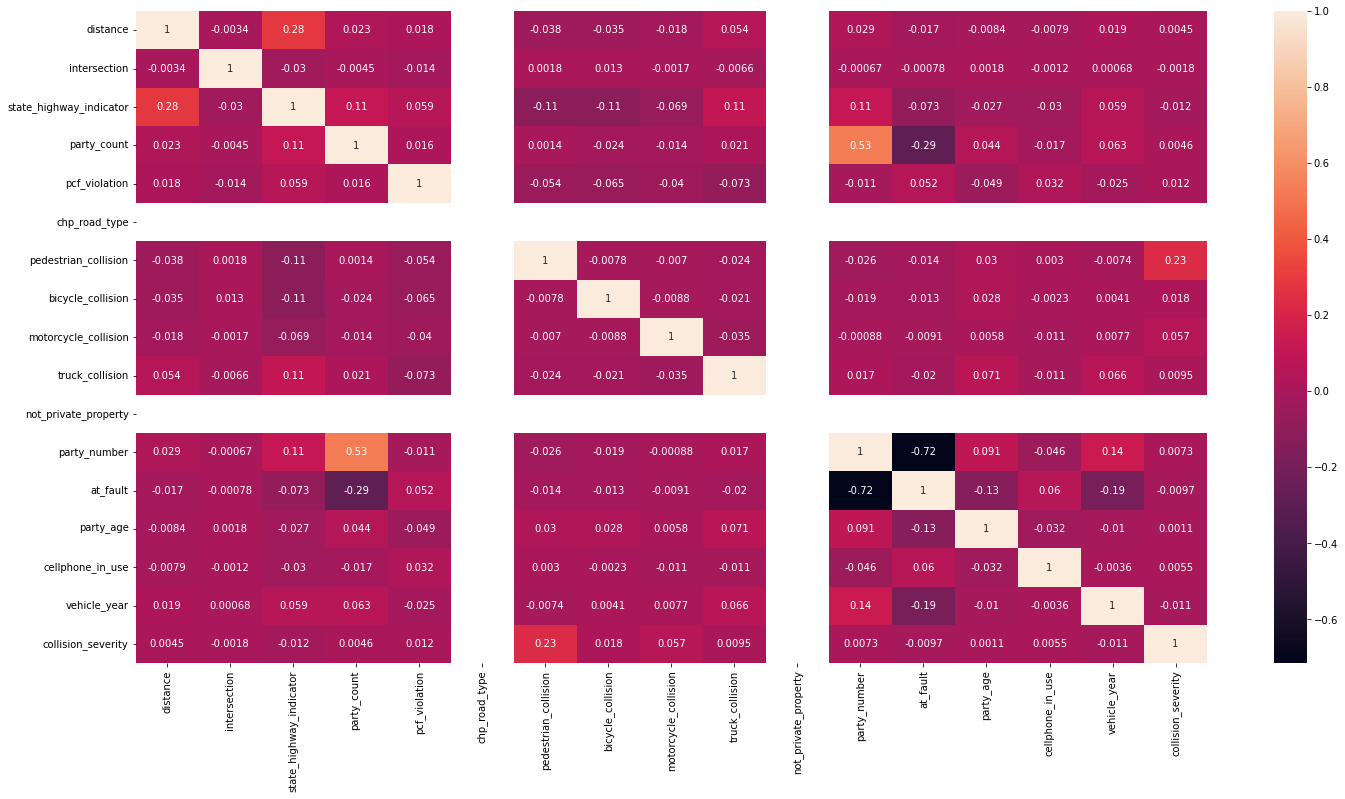

In [28]:
# checking correlation between target and other variables
ax, fig = plt.subplots(figsize = (24, 12))
sns.heatmap(mod_df.corr(), annot = True)
plt.show()

We can see that "party_number" and "at_fault" are highly anti-correlated (-0.72), so one of the variables should be removed.

In [29]:
mod_df.drop('at_fault', axis = 1, inplace = True)

We can continue here by building a base RandomForest model and test for feature importance. Those features the model deemed not important (with a value of 0) can also be removed.

A base model will also give us some intial insights into how our data performs with a RandomForest and sets a benchmark to be improved on.

We first need to split our data into train/test. However, it is clear that we are dealing with heavily imbalanced data with only 0.6% of our data labelled as 'fatal'.

In [30]:
label = mod_df.iloc[:, -1]

predictors = mod_df.iloc[:, :-1]

# the below variables are being stored for later, when we attempt feature selection using LASSO regression

log_reg_pred = mod_df.iloc[:, :-1]

log_label = mod_df.iloc[:, -1]

In [31]:
print(Counter(mod_df.iloc[:, -1]))

Counter({0: 182588, 1: 1137})


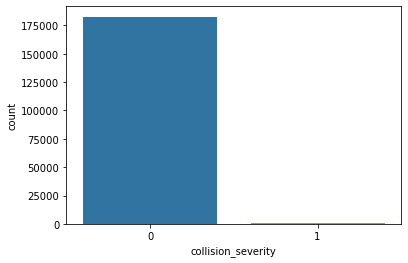

In [63]:
sns.countplot(x = 'collision_severity', data = mod_df)
plt.show()

As such, we also need to test a number of sampling techniques on our base model to see which performs best in terms of recall. For this, we will try just two sampling techniques - random oversampling and random undersampling.

First, we must split our data into train/test.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(predictors, label, test_size = 0.4, random_state = 1)

## Encoding

We need a method to convert our categorical data into numeric. There are many ways to do this, the most popular being one-hot encoding. However, this will create a superfluous amount of dummy variables and a very sparse matrix. We may also fall victim to Curse of Dimensionality here. 

One way to deal with this is to use other encoding methods, such as Target/Mean Encoding.

In essence, target encoding converts categorical variables into numeric based on the probability of their effect on the target feature.

One issue here is Data Leakage. We are essentially 'cheating' the model as it learns from a variable that contains the target itself.

Also, since we are splitting into training and testing, the average of the sample might not reflect the average of the population, and thus could lead to overfitting.

Two ways to deal with this are: k-fold cross-validation to find most accurate values and prior smoothing.


In [31]:
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

## OverSampling

In [32]:
rf = RandomForestClassifier(random_state = 1)

In [33]:
oversample = RandomOverSampler(random_state = 1)

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print(Counter(y_train_over))

Counter({0: 109546, 1: 109546})


In [34]:
over_model = rf.fit(X_train_over, y_train_over)
over_prediction = over_model.predict(X_test)

print(classification_report(y_test, over_prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     73042
           1       0.53      0.14      0.22       448

    accuracy                           0.99     73490
   macro avg       0.76      0.57      0.61     73490
weighted avg       0.99      0.99      0.99     73490



## UnderSampling 

In [35]:
undersample = RandomUnderSampler(random_state = 1)

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(Counter(y_train_under))

Counter({0: 689, 1: 689})


In [36]:
under_model = rf.fit(X_train_under, y_train_under)
under_prediction = under_model.predict(X_test)

print(confusion_matrix(y_test, under_prediction))

print(classification_report(y_test, under_prediction))

[[66784  6258]
 [  143   305]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     73042
           1       0.05      0.68      0.09       448

    accuracy                           0.91     73490
   macro avg       0.52      0.80      0.52     73490
weighted avg       0.99      0.91      0.95     73490



We can see that with oversampling, we are overfitting our data with an accuracy of 99% and have a recall score of 0.14.

Undersampling is also overfitting our data with accuracy of 91% but we are getting a much better recall at 0.68.

We will proceed with undersampling.

## Feature Importance

Now that we've fitted a model, we can continue with feature selection by calling the .feature_importances_ attribute which the model determined using the internal impurity measure (entropy or gini).

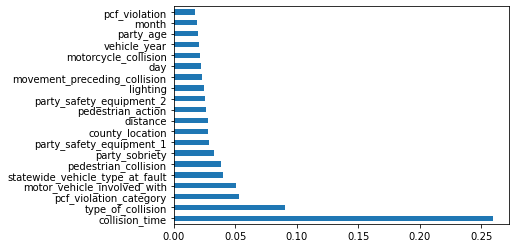

In [37]:
feat_importances = pd.Series(under_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

We can see that some features returned 0 importance - they provided no notable predictive value to our model - so we drop them.

In [38]:
feat_importance = pd.DataFrame(under_model.feature_importances_,
                              index = X_test.columns, columns = ['importance']).sort_values(
    'importance', ascending = False)

feat_importance

,importance
collision_time,0.259064
type_of_collision,0.090553
pcf_violation_category,0.052839
motor_vehicle_involved_with,0.050711
statewide_vehicle_type_at_fault,0.040185
pedestrian_collision,0.038272
party_sobriety,0.032824
party_safety_equipment_1,0.028676
county_location,0.028239
distance,0.027689


In [39]:
# Droppping labels with 0 importance

mod_df.drop(['primary_collision_factor','chp_road_type','intersection', 'not_private_property', 'year', 'party_type'], axis = 1, inplace = True)

# Dropping Duplicates 

mod_df.drop(['state_highway_indicator', 'pcf_violation', 'cellphone_use_type', 'statewide_vehicle_type_at_fault'], axis = 1, inplace = True)

Now that we've removed certain features and encoded out data, let's also look at a correlation matrix to see if there are other variables that are highly correlated.

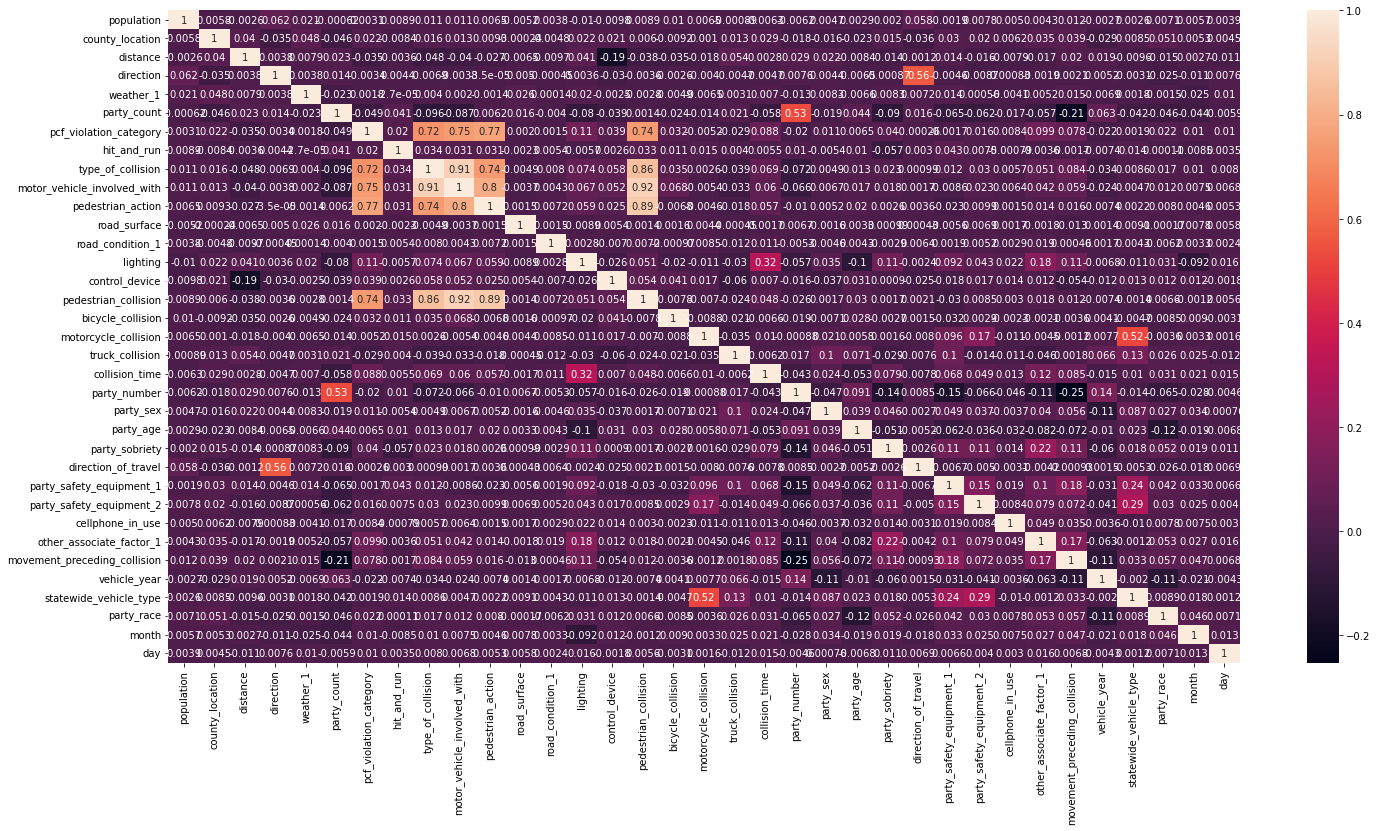

In [40]:
# Checking Correlation Matrix

ax, fig = plt.subplots(figsize = (24, 12))

corr_test = encoder.fit_transform(mod_df.iloc[:, :-1], mod_df.iloc[:, -1]) # in relation to target variable

corr_test = corr_test.corr()

sns.heatmap(corr_test, annot = True)

plt.show()

In [41]:
mod_df.drop(['pedestrian_action','type_of_collision','motor_vehicle_involved_with', 'pedestrian_collision', 'direction', 'party_number', 'statewide_vehicle_type'], axis = 1, inplace = True)

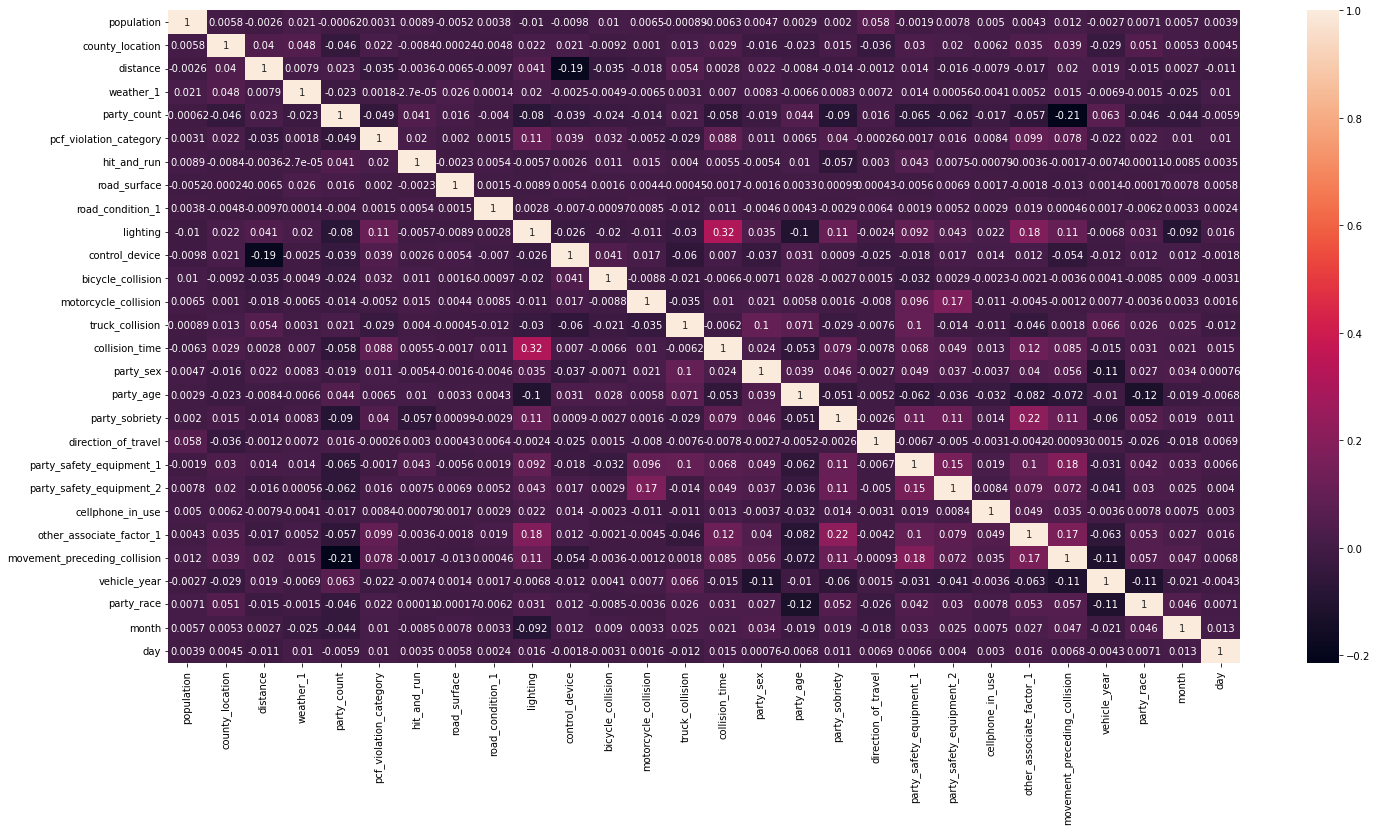

In [42]:
ax, fig = plt.subplots(figsize = (24, 12))

corr_test = encoder.fit_transform(mod_df.iloc[:, :-1], mod_df.iloc[:, -1])

corr_test = corr_test.corr()

sns.heatmap(corr_test, annot = True)

plt.show()

We have preprocessed the data as best as we can. Now it is time to work on our model.

# RandomForest

In [43]:
label = mod_df.iloc[:, -1]

predictors = mod_df.iloc[:, :-1]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(predictors, label, test_size = 0.40, random_state = 1)

In [45]:
undersample = RandomUnderSampler(random_state = 1)

X_train, y_train = undersample.fit_resample(X_train, y_train) # we only under/over sample train data

print(Counter(y_train))

Counter({0: 689, 1: 689})


In [46]:
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [47]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [48]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[62138 10904]
 [   70   378]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     73042
           1       0.03      0.84      0.06       448

    accuracy                           0.85     73490
   macro avg       0.52      0.85      0.49     73490
weighted avg       0.99      0.85      0.91     73490



Our base model after preprocessing returns a recall of 84% for class 1 and an overall accuracy of 85%.

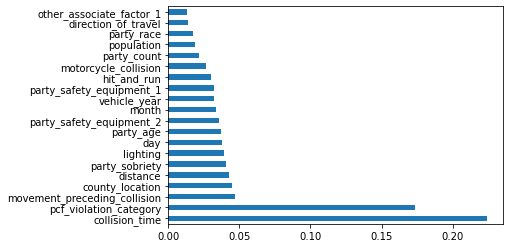

In [49]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

We can visualize some of the features the model deemed most important, including collision_time and pcf_violation_category.

In [50]:
collision_time = mod_df[mod_df['collision_severity'] == 1]

collision_time = collision_time['collision_time']

In [51]:
hours = pd.to_datetime(mod_df['collision_time'], format='%H:%M:%S').dt.hour

new_df = pd.DataFrame()

new_df['cats'] = pd.cut(hours, 
                    bins=[0,6,12,18,24], 
                    include_lowest=True, 
                    labels=['Early Morning','Morning','Afternoon','Night'])

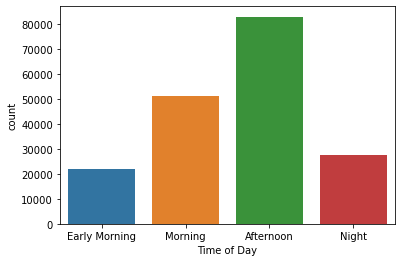

In [52]:
sns.countplot(new_df['cats'])

plt.xlabel("Time of Day")

plt.show()

We see that afternoons have the highest amount of accidents that resulted in fatalities.

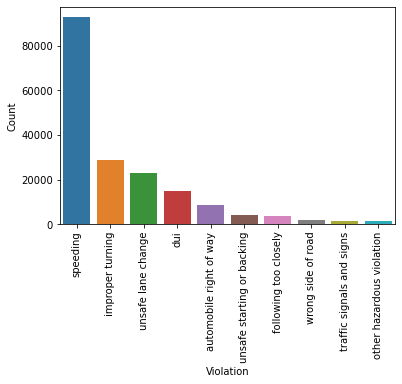

In [53]:
plt_pcf = pd.DataFrame(mod_df['pcf_violation_category'].value_counts(ascending = False)[:10].rename_axis('violation').reset_index())

sns.barplot(data= plt_pcf, x ='violation', y = 'pcf_violation_category')


plt.xlabel("Violation")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

The biggest cause of death is speeding, followed by improper turning.

# HyperParameter Tuning

Our model performs well with the default parameters, but can we improve its recall/accuracy with some fine tuning?

We will begin by initiating a randomized cross-validation search to hone in on more precise hyperparameters.

## Randomized Search

In [54]:
random_grid = {'n_estimators': np.array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split' : [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf' : [1, 2, 3, 4],
 'bootstrap' : [True, False],
 'criterion' : ['gini', 'entropy']}

In [55]:
rf_base = RandomForestClassifier(random_state = 1)
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 10,
                               random_state=1, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=1)

In [56]:
rf_random.best_params_

{'n_estimators': 2585,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_depth': 200,
 'criterion': 'gini',
 'bootstrap': True}

The randomized search returns an estimate of the best parameters for our model. From here, we can zoom in further by performing a grid search cross-validation around the stated best parameters.

GridSearchCV can be computationally very expensive, hence why we conduct RandomizedSearchCV first. The difference between the two is that, as the names suggest, a random search picks and chooses randomly while a grid search evaluates evvery possible value in the parameter space.

## GridSearch

In [57]:
param_grid = {
    'n_estimators': np.linspace(2550, 2600, 20, dtype = int),
    'max_depth': [190, 200, 210],
    'min_samples_split': [29, 30, 31],
    'min_samples_leaf': [1, 2, 3, 4]}

In [58]:
rf_grid = RandomForestClassifier(criterion = 'gini', bootstrap = True, random_state = 1)

grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)

grid_rf_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [190, 200, 210],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [29, 30, 31],
                         'n_estimators': array([2550, 2552, 2555, 2557, 2560, 2563, 2565, 2568, 2571, 2573, 2576,
       2578, 2581, 2584, 2586, 2589, 2592, 2594, 2597, 2600])})

In [59]:
print(grid_rf_search.best_estimator_)
grid_rf_search.best_params_

RandomForestClassifier(max_depth=190, min_samples_split=29, n_estimators=2597,
                       random_state=1)


{'max_depth': 190,
 'min_samples_leaf': 1,
 'min_samples_split': 29,
 'n_estimators': 2597}

In [60]:
rf_tuned = RandomForestClassifier(max_depth = 190,
                                  min_samples_leaf = 1,
                                  min_samples_split = 29,
                                  n_estimators = 2597,
                                  criterion = 'gini',
                                  bootstrap = True,
                                  random_state = 1)
rf_tuned.fit(X_train, y_train)
tuned_pred = rf_tuned.predict(X_test)

In [61]:
print(confusion_matrix(y_test, tuned_pred))
print(classification_report(y_test, tuned_pred))

[[61343 11699]
 [   66   382]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     73042
           1       0.03      0.85      0.06       448

    accuracy                           0.84     73490
   macro avg       0.52      0.85      0.49     73490
weighted avg       0.99      0.84      0.91     73490



We can see that our overall accuracy stayed the same but recall increased by 1%. Nonetheless, this is a good score.

## Tree Visualization

In [63]:
plt.figure(figsize = (150,150))
tree.plot_tree(rf_tuned.estimators_[1], filled = True, class_names = ['safe', 'fatal'], 
                             feature_names = X_train.columns, label = 'root')

[Text(0.5242424242424243, 0.96875, 'hit_and_run <= 0.258\ngini = 0.499\nsamples = 861\nvalue = [666, 712]\nclass = fatal'),
 Text(0.5, 0.90625, '0.0\n43\n[70, 0]\nsafe'),
 Text(0.5484848484848485, 0.90625, 'lighting <= 0.389\n0.496\n818\n[596, 712]\nfatal'),
 Text(0.32727272727272727, 0.84375, 'party_safety_equipment_2 <= 0.893\n0.451\n389\n[401, 210]\nsafe'),
 Text(0.30303030303030304, 0.78125, 'party_count <= 4.5\n0.431\n372\n[398, 182]\nsafe'),
 Text(0.2787878787878788, 0.71875, 'pcf_violation_category <= 0.466\n0.415\n354\n[390, 162]\nsafe'),
 Text(0.21818181818181817, 0.65625, 'bicycle_collision <= 0.5\n0.265\n250\n[344, 64]\nsafe'),
 Text(0.19393939393939394, 0.59375, 'collision_time <= 0.549\n0.248\n245\n[342, 58]\nsafe'),
 Text(0.1696969696969697, 0.53125, 'collision_time <= 0.234\n0.151\n219\n[334, 30]\nsafe'),
 Text(0.14545454545454545, 0.46875, '0.0\n102\n[170, 0]\nsafe'),
 Text(0.19393939393939394, 0.46875, 'movement_preceding_collision <= 0.667\n0.261\n117\n[164, 30]\nsafe

# Logistic Regression

Another approach to feature selection would've been to use Logistic Regression and its inbuilt L1 regularization (or LASSO) method to eliminate features that aren't important.

Regularization constraints the size of the model coefficients by reducing the variance of the model.

In [119]:
col_at_end = ['collision_severity']

log_df = log_df[[c for c in log_df if c not in col_at_end] 
        + [c for c in col_at_end if c in log_df]]

In [121]:
log_df['collision_severity'] = [ 1 if x == 'fatal' else 0 for x in log_df['collision_severity']]


In [123]:
log_reg_pred = log_df.iloc[:, :-1]

log_label = log_df.iloc[:, -1]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(log_reg_pred, log_label, test_size = 0.40, random_state = 1)

undersample = RandomUnderSampler(random_state = 1)

X_train_log, y_train_log = undersample.fit_resample(X_train_log, y_train_log)

print(Counter(y_train_log))

Counter({0: 1591, 1: 1591})


In [124]:
encoder = TargetEncoder()
X_train_log = encoder.fit_transform(X_train_log, y_train_log)
X_test_log = encoder.transform(X_test_log) 

The parameter we'll be tuning in the Logistic Regression model is 'C' - a floating point number that is the "inverse of regularization strength." For C, the smaller values specify stronger regularization.

In [125]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train_log)

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]} 

lr_model = LogisticRegression(penalty ='l1', solver='liblinear')
gs_model = GridSearchCV(estimator = lr_model, param_grid = param)
gs_model.fit(X_std, y_train_log)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_std, y_train_log)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

We can inspect the coefficients dervied from the Logistic Regression model. Each coefficient corresponds to a variable in our dataset. The coefficients with a value of 0 are considered redundant by our model and therefore can be removed.

In [126]:
coef = model.coef_[0]

red_features = pd.Series(X_train_log.columns)[list(coef==0)]

red_features

4                 intersection
8     primary_collision_factor
10               pcf_violation
19               chp_road_type
20        pedestrian_collision
24        not_private_property
29                  party_type
dtype: object

We removed 7 variables by implementing Logistic Regression and ended with 38 variables in total - 10 more than what we worked with on our RandomForest model after the extensive preprocessing process.

In [127]:
print(len(log_df.columns) - len(red_features))
print(mod_df.columns)

38

This last section was merely an exercise in seeing how we can tackle feature selection in another way, and why Logistic Regression is so popular in both its simplicity and efficiency as a supervised machine learning model.

# Conclusion

In this project, we analysed traffic collision data to see if we can predict whether an accident will result in a fatality or not.

We used a RandomForest classifier to do this, and acheived a recall of 85%.

One major hurdle throughout this project was feature selection and preparing the data for modeling. It is evident that a number of approachs can be taken, but ultimately there is no one size fits all solution. It is a matter of testing and trying to see which methods generalize the best.